- tf.Dataset
- batchsize
- Sequential 
- callback (niektóre)
- krzywe uczenia
- zapisywanie/odczytywanie modeli
- regresja/klasyfikacja (autompg/kotki)
- random seed


In [60]:
!pip install pyyaml h5py

In [24]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tensorflow import keras as krs
import seaborn as sns

from tensorflow.keras import Sequential
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from keras.layers import (
    Dense, 
    Conv2D,
    Flatten,
    Input,
    MaxPooling2D,
    Dropout,
    Rescaling
)

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger


# Importing data

In [2]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip',
                                      origin=_URL, 
                                      extract=True, 
                                      cache_dir='.')
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

In [3]:
BATCH_SIZE = 32
IMG_SIZE = (160, 160)

In [4]:
train = krs.utils.image_dataset_from_directory(train_dir,
                                               shuffle=True,
                                               batch_size=BATCH_SIZE,
                                               image_size=IMG_SIZE,
                                               seed=7)

validation = krs.utils.image_dataset_from_directory(validation_dir,
                                                   shuffle=True,
                                                   batch_size=BATCH_SIZE,
                                                   image_size=IMG_SIZE,
                                                   seed=7)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [5]:
train

<BatchDataset element_spec=(TensorSpec(shape=(None, 160, 160, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [6]:
classes = train.class_names
classes

['cats', 'dogs']

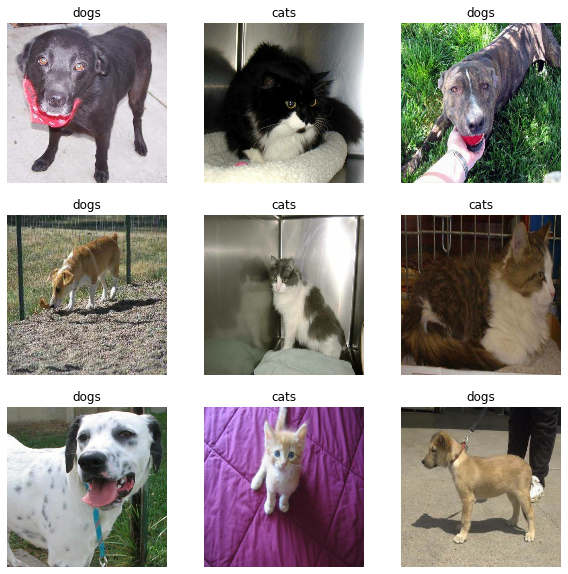

In [7]:
plt.figure(figsize=(10, 10))
for images, labels in train.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(classes[labels[i]])
        plt.axis("off")

In [8]:
# Number of batches in validations set
val_batches = tf.data.experimental.cardinality(validation)
test = validation.take(val_batches // 5)
validation = validation.skip(val_batches // 5)

In [9]:
tf.data.experimental.cardinality(validation)

<tf.Tensor: shape=(), dtype=int64, numpy=26>

In [10]:
tf.data.experimental.cardinality(test)

<tf.Tensor: shape=(), dtype=int64, numpy=6>

In [44]:
def create_model():
    model = Sequential([
        Rescaling(1. / 255, input_shape = (IMG_SIZE[0], IMG_SIZE[1], 3)),
        Conv2D(32, 3, padding='same', activation='relu'),
        MaxPooling2D(),
        Conv2D(16, 3, padding='same', activation='relu'),
        MaxPooling2D(),
        Conv2D(8, 3, padding='same', activation='relu'),
        MaxPooling2D(),
        Flatten(),
        Dense(32, activation='relu'),
        Dense(len(classes))
    ])
    return model

In [45]:
model = create_model()

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 160, 160, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 160, 160, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 80, 80, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 80, 80, 16)        4624      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 40, 40, 16)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 40, 40, 8)         1

In [62]:
model.compile(optimizer='adam',
              loss=SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [63]:
tf.random.set_seed(7)
path_to_model1 = os.path.join('models', 'model1.ckpt')
path_to_history1 = os.path.join('models', 'history1.csv')

n_epochs = 30
callbacks = [EarlyStopping(monitor='val_loss', patience=5),
             ModelCheckpoint(path_to_model1, ),
             CSVLogger(path_to_history1, append=True)]

In [64]:
history = model.fit(train, 
         batch_size=BATCH_SIZE,
         epochs=n_epochs,
         validation_data=validation,
         callbacks=callbacks)

Epoch 1/30
63/63 [==============================] - 23s 365ms/step - loss: 0.6957 - accuracy: 0.5265 - val_loss: 0.6924 - val_accuracy: 0.5829
Epoch 2/30
63/63 [==============================] - 23s 360ms/step - loss: 0.6889 - accuracy: 0.5490 - val_loss: 0.6926 - val_accuracy: 0.4864
Epoch 3/30
63/63 [==============================] - 22s 352ms/step - loss: 0.6711 - accuracy: 0.5910 - val_loss: 0.6410 - val_accuracy: 0.6498
Epoch 4/30
63/63 [==============================] - 22s 355ms/step - loss: 0.6125 - accuracy: 0.6715 - val_loss: 0.6524 - val_accuracy: 0.6275
Epoch 5/30
63/63 [==============================] - 22s 347ms/step - loss: 0.5859 - accuracy: 0.6920 - val_loss: 0.6462 - val_accuracy: 0.6213
Epoch 6/30
63/63 [==============================] - 21s 337ms/step - loss: 0.5294 - accuracy: 0.7485 - val_loss: 0.6254 - val_accuracy: 0.6621
Epoch 7/30
63/63 [==============================] - 23s 369ms/step - loss: 0.5276 - accuracy: 0.7425 - val_loss: 0.6051 - val_accuracy: 0.6943

In [20]:
history

In [65]:
model = tf.keras.models.load_model(path_to_model1)

In [66]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 160, 160, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 160, 160, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 80, 80, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 80, 80, 16)        4624      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 40, 40, 16)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 40, 40, 8)        

In [71]:
history = pd.read_csv(path_to_history1)

In [72]:
history

,epoch,accuracy,loss,val_accuracy,val_loss
0,0,0.5265,0.695715,0.582921,0.692358
1,1,0.5490,0.688865,0.486386,0.692585
2,2,0.5910,0.671089,0.649752,0.641049
3,3,0.6715,0.612537,0.627475,0.652353
4,4,0.6920,0.585925,0.621287,0.646191
5,5,0.7485,0.529411,0.662129,0.625395
6,6,0.7425,0.527614,0.694307,0.605064
7,7,0.7630,0.479797,0.672030,0.618872
8,8,0.7990,0.416377,0.668317,0.660957
9,9,0.8090,0.405204,0.693069,0.659804


In [73]:
def learning_curves(history):
    if isinstance(history, pd.DataFrame):
        acc = history['accuracy']
        val_acc = history['val_accuracy']

        loss = history['loss']
        val_loss = history['val_loss']
    else:
        acc = history.history['accuracy']
        val_acc = history.history['val_accuracy']

        loss = history.history['loss']
        val_loss = history.history['val_loss']
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend()
    plt.ylabel('Accuracy')
    plt.ylim([min(plt.ylim()),1])
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')

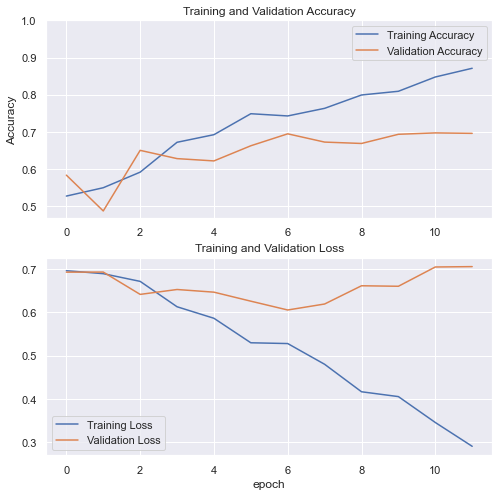

In [74]:
learning_curves(history)

In [75]:
model.evaluate(test)

6/6 [==============================] - 1s 80ms/step - loss: 0.6826 - accuracy: 0.6979


[0.6825589537620544, 0.6979166865348816]